# Определение возраста покупателей

В данной задаче мы будем помогать супермаркету 'Хлеб-Соль' определять возраст покупателей. Для этого нам предоставили фото покупателей и их возраст.

Для начала мы проведем исследовательских анализ данных, посмотрим на распределение покупателей по возрасту, а также посмотрим на данные в целом, взяв несколько случайных примеров.

После этого создадим модель для прогнозирования и попробуем добиться хорошего результата в прогнозе. Он будет определяться при помощи метрики MAE, которая не должна быть больше 8 на тестовых данных.

В конце нашей работы сделаем вывод об успешной модели.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [2]:
RANDOM_STATE = 42

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

Посмотрим на наш датасет.

In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


В первой колонке содержится имя файла, а во второй - возраст человека на изображении.

In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Пропуски отсутствуют.

Теперь посмотрим на распределение возрастов в нашем датасете.

In [6]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Получается, что средний возраст составляет 31 год, медианный - 29 лет. Минимальный возраст - 1 год, а максимальный - 100 лет. Для наглядности визиулизируем наши данные.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Размер выборки выведен. Выборка относительно небольшая, но мы еще можем нарастить ее, применяя аугментации


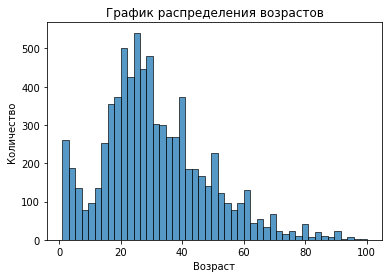

In [7]:
plt.title('График распределения возрастов')
sns.histplot(labels['real_age'])
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

Распределение возрастов похоже на нормальное, но есть некоторые пики. Например, много значений близких к 0. Такое может быть, потому что не получилось определить возраст и было указано значение 1.

Также видны пики у возрастов 40, 50, 60, 70, 80, 90 лет. Возможно, имело место быть округление, тк более сложно определить точный возраст у людей постарше.

Для большей наглядности, напечатаем 15 случайных изображений из нашего датасета.

Возраст:  1
Разрешение изображения:  (163, 163, 3)


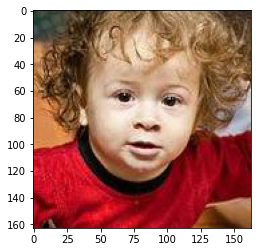

Возраст:  46
Разрешение изображения:  (192, 191, 3)


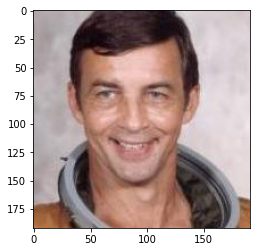

Возраст:  35
Разрешение изображения:  (300, 301, 3)


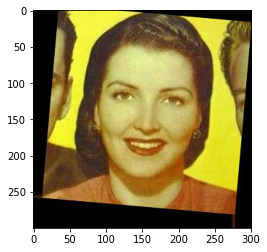

Возраст:  23
Разрешение изображения:  (909, 909, 3)


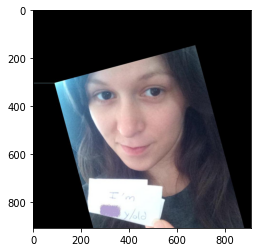

Возраст:  47
Разрешение изображения:  (782, 782, 3)


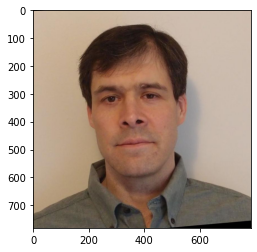

Возраст:  26
Разрешение изображения:  (618, 618, 3)


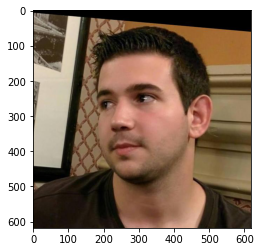

Возраст:  20
Разрешение изображения:  (293, 294, 3)


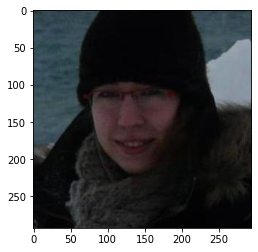

Возраст:  17
Разрешение изображения:  (307, 307, 3)


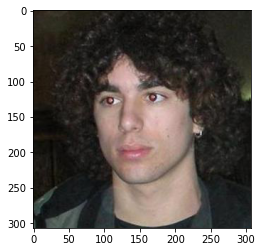

Возраст:  25
Разрешение изображения:  (496, 497, 3)


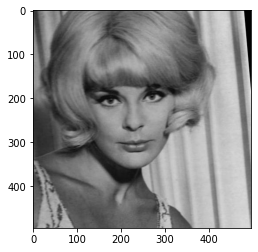

Возраст:  27
Разрешение изображения:  (237, 237, 3)


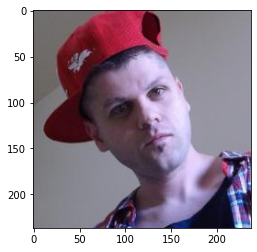

Возраст:  47
Разрешение изображения:  (327, 327, 3)


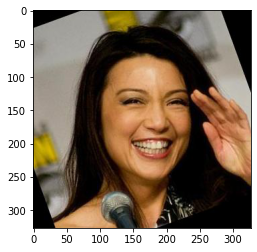

Возраст:  26
Разрешение изображения:  (328, 328, 3)


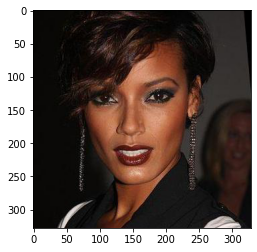

Возраст:  37
Разрешение изображения:  (394, 394, 3)


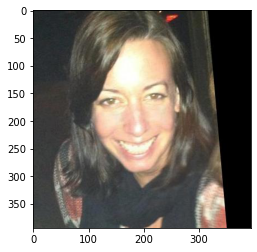

Возраст:  31
Разрешение изображения:  (1093, 1093, 3)


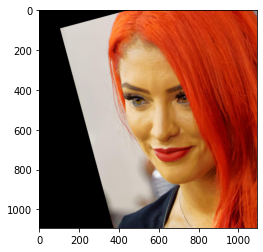

Возраст:  94
Разрешение изображения:  (772, 772, 3)


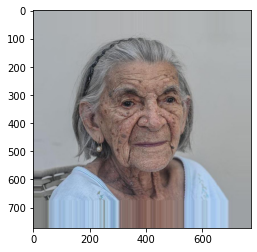

In [8]:
#создадим случайную выборку из 15 файлов.
labels_15 = labels.sample(15, random_state=RANDOM_STATE)
#создадим цикл. возьмем каждое из выбранных изображений.
#напечатаем его, а также отобразим разрешение и информацию о возрасте
for i in range(len(labels_15)):
    image = Image.open('/datasets/faces/final_files/' + labels_15.iloc[i, 0])
    image_array = np.array(image)
    plt.imshow(image_array)
    print('Возраст: ', labels_15.iloc[i, 1])
    print('Разрешение изображения: ', image_array.shape)
    plt.show()

Видно, что возраста похожи на правду, а также то, что у всех изображений различное разрешение. Поэтому при дальнешей работе придется применить ImageDataGenerator. Из плюсов можно выделить то, что лица на изображениях занимают большую часть, что хорошо скажется на дальнейшем обучении.

## Обучение модели

Для прогноза воспользуемся нейронной сетью для изображений ResNet50. Создадим функции для обработки тренировочной и тестовой выборок. Будем брать изображения при помощи ImageDataGenerator. Хорошим результатом будет считаться MAE < 8.

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def load_train(path):
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

    train_data = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
 	directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
	batch_size=32,
        target_size=(224, 224),
        class_mode='raw',
        subset='training',
        seed=12345)   
    return train_data

def load_test(path):
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

    test_data = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
 	directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
	batch_size=32,
        target_size=(224, 224),
        class_mode='raw',
        subset='validation',
        seed=12345)  
    return test_data

def create_model(input_shape):
    optimizer = Adam()
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False) 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=7,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```


```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/7
2025-04-09 21:34:24.821209: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-04-09 21:34:25.261059: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 65s - loss: 223.1517 - mae: 11.3123 - val_loss: 382.7490 - val_mae: 14.6285
Epoch 2/7
178/178 - 51s - loss: 140.5859 - mae: 9.0483 - val_loss: 285.2737 - val_mae: 12.8097
Epoch 3/7
178/178 - 46s - loss: 106.4337 - mae: 7.9454 - val_loss: 380.0990 - val_mae: 14.5688
Epoch 4/7
178/178 - 50s - loss: 87.9868 - mae: 7.1865 - val_loss: 282.4647 - val_mae: 12.4668
Epoch 5/7
178/178 - 50s - loss: 68.7530 - mae: 6.4038 - val_loss: 166.3283 - val_mae: 9.7097
Epoch 6/7
178/178 - 50s - loss: 44.9056 - mae: 5.1943 - val_loss: 126.8135 - val_mae: 8.6995
Epoch 7/7
178/178 - 45s - loss: 31.0394 - mae: 4.2977 - val_loss: 101.4408 - val_mae: 7.6352
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 12s - loss: 101.4408 - mae: 7.6352
```

## Анализ обученной модели

Наша нейронная сеть справилась с задачей и наш целевой показатель (ошибка MAE) получился < 8, что является неплохим результатом.

Такой результат получился благодаря использованию модели ResNet50, которая сильна в работе с изображениями. Мы заменили в ней последний слой на 1 нейрон с фунцией активации 'relu', тк перед нами стояла задача регрессии.